# TF-Keras Integration

EvolvePy provides integration classes for evolve neural networks with Tensorflow. The simplest and most direct way to evolve a model is using an EvolutionaryModel.

In [1]:
import evolvepy as ep

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

# Prepare the data

Let's start preparing the data. For this example, we will use the IRIS dataset. It is a classification dataset that contains measurements of flower petuls and sepels to classify them into three different species.

In [2]:
import os


train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

dataset = pd.read_csv(train_dataset_fp, names=column_names, skiprows=1)

We gonna use 80% of the dataset for training and 20% for validation.

In [3]:
x = dataset[feature_names].to_numpy()
y = dataset[label_name].to_numpy()

n = x.shape[0]
n_train = int(0.8*n)
n_val = n-n_train

x_val = x[n_train:]
y_val = y[n_train:]

x = x[:n_train]
y = y[:n_train]

# Prepare the model and the generator

Let's take a simple fully connected network and create a utility function to generate the model. The EvolutionaryModel it's a kind of Sequential model, so we can instantiate it by passing in a list of layers.

In [4]:
from evolvepy.integrations.tf_keras import EvolutionaryModel

def create_model():
    model = EvolutionaryModel([keras.layers.Dense(10, activation="relu", input_shape=(4,)),
                                keras.layers.Dense(10, activation="relu"),
                                keras.layers.Dense(3)])
    return model


The model provides the descriptor we need to create the generator, which will have elitism, combination and mutation.

In [5]:
def create_generator(model):
    first = ep.generator.Layer()
    combine = ep.generator.CombineLayer(ep.generator.selection.tournament, ep.generator.crossover.one_point)
    mutation = ep.generator.mutation.NumericMutationLayer(ep.generator.mutation.sum_mutation, 1.0, 0.5, (-0.5, 0.5))
    filter0 = ep.generator.FilterFirsts(143)
    sort = ep.generator.Sort()
    filter1 = ep.generator.FilterFirsts(7)
    concat = ep.generator.Concatenate()

    first.next = combine
    combine.next = mutation
    combine.next = filter0
    filter0.next = concat

    first.next = sort
    sort.next = filter1
    filter1.next = concat

    #Creates the generator using the descriptor.
    generator = ep.generator.Generator(first_layer=first, last_layer=concat, descriptor=model.descriptor)

    return generator, mutation.name

# One batch

Our first test will use only one batch per epoch. In this way, each epoch will evolve a generation. We will also use a dynamic mutation to allow us to refine our weights.

Notice how the build receives the generator, population size, and EvolvePy callbacks.

In [6]:
model = create_model()
generator, mut_name = create_generator(model)

dyn_mut = ep.callbacks.DynamicMutation([mut_name], patience=2, refinement_steps=20, refinement_patience=2, exploration_steps=10, exploration_patience=2, refinement_divider=3)

# Compiles the model with the generator, population size and callbacks
model.compile(generator, 150, [dyn_mut], loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

Let's fit and see the results. Notice how the batch size is the same amount of training data.

(This may take a while)

In [ ]:
hist = model.fit(x, y, validation_data=(x_val, y_val), epochs = 100, batch_size=n_train)

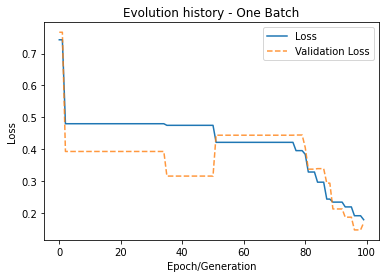

In [63]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"], "--", alpha=0.8)

plt.title("Evolution history - One Batch")
plt.legend(["Loss", "Validation Loss"])
plt.xlabel("Epoch/Generation")
plt.ylabel("Loss")
plt.show()

We can see how the evolution process managed to reduce the loss.

![](TF-KerasIntegration-Figure1.jpg)

#  Multiple batchs

To avoid overfitting or memory overflow while evolving a model, it can be useful to use multiple batches. There are some important details to note in this case.

Note that we are no longer using dynamic mutation. As we are using multiple batches, the training data varies with each generation, which generates variations in fitness that can generate unexpected behaviors in dynamic mutation.

In [47]:
model = create_model()
generator, mut_name = create_generator(model)

mem_log = ep.callbacks.MemoryStoreLogger(log_population=True)

model.compile(generator, 150, [mem_log], loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

Notice how we split the data into 4 batches when training this time.

The training process will take longer, as in each epoch the generation will evolve 4 times.

In [ ]:
hist_batchs = model.fit(x, y, validation_data=(x_val, y_val), epochs = 100, batch_size=n_train//4)

Note that although we trained for 100 epochs, the number of generations logged is 400 (4 batches x 100 epochs).

In [49]:
len(mem_log.log)

400

Let's see the result.

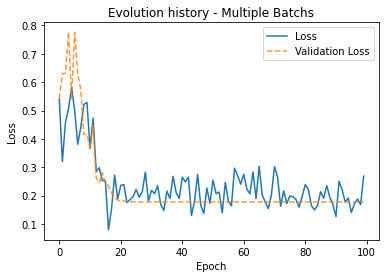

In [64]:
plt.plot(hist_batchs.history["loss"])
plt.plot(hist_batchs.history["val_loss"], "--", alpha=0.8)

plt.title("Evolution history - Multiple Batchs")
plt.legend(["Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Again, the loss is decreased every epoch.

![](TF-KerasIntegration-Figure2.jpg)

# Comparison

Let's compare models trained with evolutionary processes with a model trained using a gradient optimizer, in this case Adam.

In [51]:
model = keras.Sequential([keras.layers.Dense(10, activation="relu", input_shape=(4,)),
                                keras.layers.Dense(10, activation="relu"),
                                keras.layers.Dense(3)])

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
hist_tf = model.fit(x, y, epochs=100, verbose=0, validation_data=(x_val, y_val))

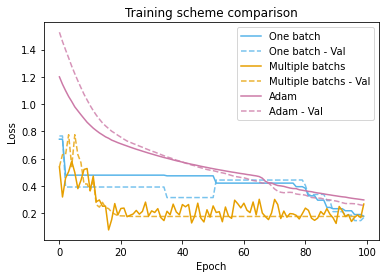

In [65]:
plt.plot(hist.history["loss"], color="#56B4E9")
plt.plot(hist.history["val_loss"], "--", color="#56B4E9", alpha=0.8)

plt.plot(hist_batchs.history["loss"], color="#E69F00")
plt.plot(hist_batchs.history["val_loss"], "--", color="#E69F00", alpha=0.8)

plt.plot(hist_tf.history["loss"], color="#CC79A7")
plt.plot(hist_tf.history["val_loss"], "--", color="#CC79A7", alpha=0.8)

plt.legend(["One batch", "One batch - Val", "Multiple batchs", "Multiple batchs - Val", "Adam", "Adam - Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training scheme comparison")
plt.show()

Note how both evolved models can achieve results comparable to those obtained with Adam in fewer epochs. However, it is necessary to consider that they take considerably longer to train, because at each epoch it is necessary to transfer the weights of each individual to the model and evaluate it. There are some cases where it might be more interesting to use an evolutionary algorithm to optimize neural networks, as will be shown in other examples.

![](TF-KerasIntegration-Figure3.jpg)